In [1]:
import torch
from torch import nn
from torch import optim
from torch import functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
bs=64
worker = 2
latent_features = 3

In [3]:
tfms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])
data = MNIST('../data/', train=True, transform=tfms, download=True)
dl = DataLoader(data, batch_size=bs, num_workers=worker)

In [4]:
class Encoder(nn.Module):
  def __init__(self, channels, feature_map_size):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(in_channels=channels, out_channels=feature_map_size, kernel_size=4, stride=2, padding=1, bias=False),
        nn.Tanh(),
        nn.Dropout(0.2),
        nn.Conv2d(feature_map_size, feature_map_size*2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(feature_map_size*2),
        nn.Tanh(),
        nn.Conv2d(feature_map_size*2, feature_map_size*4, 4, 2, 1, bias=False),
        nn.AdaptiveAvgPool2d((1,1)),
    )

    self.linear = nn.Linear(feature_map_size*4, latent_features)

  def forward(self, x):
    x = self.encoder(x)
    bs = x.shape[0]
    return self.linear(x.view(bs, -1))  

In [5]:
class Decoder(nn.Module):
  def __init__(self, channels, feature_map_size):
    super().__init__()
    self.decoder = nn.Sequential(
    nn.ConvTranspose2d(feature_map_size*4, feature_map_size*2, 4, 2, 1, bias=False),
    nn.BatchNorm2d(feature_map_size*2),
    nn.Tanh(),
    nn.ConvTranspose2d(feature_map_size*2, feature_map_size, 4, 2, 1, bias=False),
    nn.BatchNorm2d(feature_map_size),
    nn.Tanh(),
    nn.ConvTranspose2d(feature_map_size, feature_map_size, 4, 2, 1, bias=False),
    nn.BatchNorm2d(feature_map_size),
    nn.Tanh(),
    nn.ConvTranspose2d(feature_map_size, feature_map_size, 3, 2, 1, bias=False),
    nn.BatchNorm2d(feature_map_size),
    nn.Tanh(),
    nn.ConvTranspose2d(feature_map_size, channels, 2, 2, 1, bias=False),
    )

    self.inv_linear = nn.Linear(latent_features, feature_map_size*4)

  def forward(self, x):
    x = self.inv_linear(x)
    bs = x.shape[0]
    return self.decoder(x.view(bs, -1, 1, 1))

In [6]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = Encoder(1, 8)
    self.decoder = Decoder(1, 8)

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return encoded, decoded

In [7]:
model = AutoEncoder()
model

AutoEncoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(1, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): Tanh()
      (2): Dropout(p=0.2, inplace=False)
      (3): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Tanh()
      (6): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): AdaptiveAvgPool2d(output_size=(1, 1))
    )
    (linear): Linear(in_features=32, out_features=3, bias=True)
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(8, eps=

In [8]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

In [17]:
def visualize(dl):
  model.eval()
  with torch.no_grad():
    imgs, _ = next(iter(dl))
    _, decoded_imgs = model(imgs)
    decoded_imgs = decoded_imgs.view(bs, 1, 28, 28).detach()
  
  fig, ax = plt.subplots(2, 1, figsize = (40,15))
  for axis, img in zip(ax, [imgs, decoded_imgs]):
    axis.axis('off')
    axis.imshow(np.transpose(torchvision.utils.make_grid(img, padding=5, normalize=True), (1,  2, 0)))

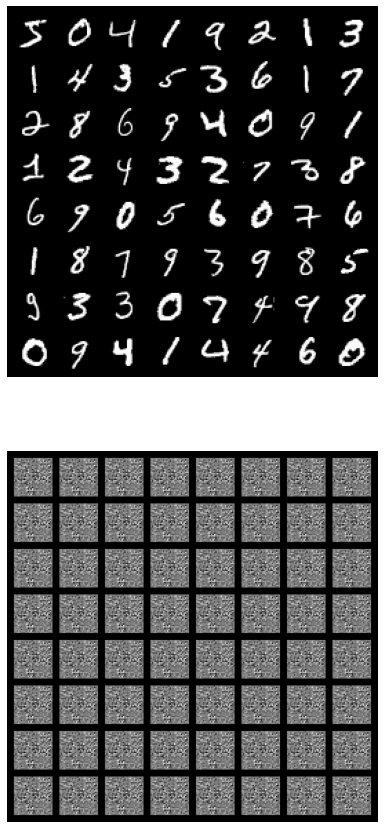

In [18]:
visualize(dl)

In [20]:
num_epochs = 10

for i in range(num_epochs):
  total_loss = 0.0
  model.train()
  for x, _ in dl:
    optimizer.zero_grad()
    enc, dec = model(x)
    loss = loss_fn(dec, x)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  
  total_loss /= len(dl)

  print(f'| Epoch: {(i+1):02} | Loss: {total_loss :.05f} |')

| Epoch: 01 | Loss: 0.19157 |
| Epoch: 02 | Loss: 0.18618 |
| Epoch: 03 | Loss: 0.18241 |
| Epoch: 04 | Loss: 0.17962 |
| Epoch: 05 | Loss: 0.17776 |
| Epoch: 06 | Loss: 0.17624 |
| Epoch: 07 | Loss: 0.17495 |
| Epoch: 08 | Loss: 0.17393 |
| Epoch: 09 | Loss: 0.17313 |
| Epoch: 10 | Loss: 0.17235 |


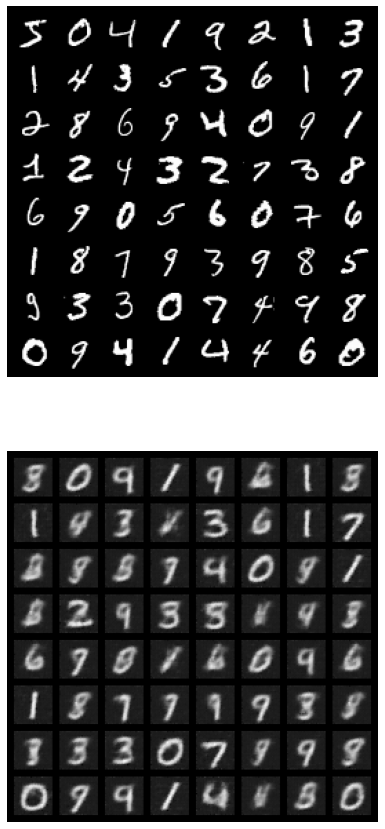

In [21]:
visualize(dl)

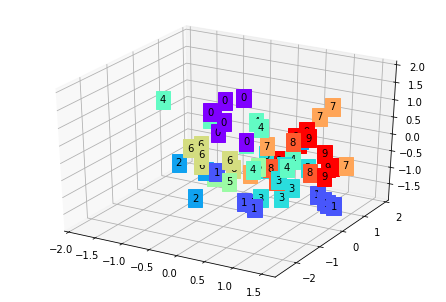

In [24]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

model.eval()
with torch.no_grad():
  imgs, labels = next(iter(dl))
  encoded_data = model.encoder(imgs)

fig = plt.figure(2)
ax = Axes3D(fig)
X, Y, Z = encoded_data.data[:, 0].numpy(), encoded_data.data[:, 1].numpy(), encoded_data.data[:,2].numpy()
values = labels.numpy()
for x, y, z, s in zip(X, Y, Z, values):
  c = cm.rainbow(int(255*s/9))
  ax.text(x, y, z, s, backgroundcolor=c)
ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(), Z.max())
plt.show()